# **Exploratory Data Analysis**

In [ ]:
# Basic System & Math Utilities
import os
import math
import glob

# Audio Processing Libraries
import wave
import librosa
import librosa.display
import soundfile
from scipy.io.wavfile import read

# Data Handling & Numerical Computing
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Machine Learning / Deep Learning
import tensorflow as tf
from tqdm.notebook import tqdm

# Jupyter Audio Playback
import IPython.display as ipd

from tqdm.notebook import tqdm

#### **Explore Dataset Directory**

In [ ]:
import kagglehub
vbookshelf_respiratory_sound_database_path = kagglehub.dataset_download('vbookshelf/respiratory-sound-database')

print('Data source import complete.')

100%|██████████| 3.69G/3.69G [00:41<00:00, 95.2MB/s]

Extracting files...


Data source import complete.


The dataset used in this study is the Respiratory Sound Database, originally acquired from the Biomedical Health Informatics Challenge hosted by Aristotle University of Thessaloniki (Rocha et al., 2019). This database was curated by research teams from Portugal and Greece and is publicly accessible via Kaggle.

The dataset comprises 920 annotated audio recordings of respiratory sounds from 126 patients, with clips ranging from 10 to 90 seconds in length. Each recording includes corresponding annotation files that describe the presence of respiratory anomalies such as wheezes, crackles, or both, as well as demographic and diagnostic information for each patient. The dataset offers a comprehensive repository of real-world respiratory sound data, suitable for training and evaluating machine learning models targeting respiratory disease detection.

In [ ]:
os.listdir(vbookshelf_respiratory_sound_database_path)

['respiratory_sound_database',
 'Respiratory_Sound_Database',
 'demographic_info.txt']

#### **Load and Merge Demographics & Diagnosis CSVs**

In [ ]:
df_no_diagnosis = pd.read_csv(
    os.path.join(vbookshelf_respiratory_sound_database_path, 'demographic_info.txt'),
    names=['Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)',
           'Child Weight (kg)', 'Child Height (cm)'],
    delimiter=' '
)

diagnosis = pd.read_csv(
    os.path.join(vbookshelf_respiratory_sound_database_path, 'Respiratory_Sound_Database',
                 'Respiratory_Sound_Database', 'patient_diagnosis.csv'),
    names=['Patient number', 'Diagnosis']
)

In [ ]:
# Merge demographics + diagnosis
df = df_no_diagnosis.join(
    diagnosis.set_index('Patient number'),
    on='Patient number',
    how='left'
)

df

Patient number    Age  Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0               101   3.00    F                NaN               19.0   
1               102   0.75    F                NaN                9.8   
2               103  70.00    F              33.00                NaN   
3               104  70.00    F              28.47                NaN   
4               105   7.00    F                NaN               32.0   
..              ...    ...  ...                ...                ...   
121             222  60.00    M                NaN                NaN   
122             223    NaN  NaN                NaN                NaN   
123             224  10.00    F                NaN               32.3   
124             225   0.83    M                NaN                7.8   
125             226   4.00    M                NaN               16.7   

     Child Height (cm)  Diagnosis  
0                 99.0       URTI  
1                 73.0    Healthy  
2                  NaN     Asthma  
3                  NaN       COPD  
4                135.0       URTI  
..                 ...        ...  
121                NaN       COPD  
122                NaN       COPD  
123              143.0    Healthy  
124               74.0    Healthy  
125              103.0  Pneumonia  

[126 rows x 7 columns]

#### **List All Filenames**

In [ ]:
root = os.path.join(vbookshelf_respiratory_sound_database_path, 'Respiratory_Sound_Database', 'Respiratory_Sound_Database', 'audio_and_txt_files') + os.sep

filenames = [s.split('.')[0] for s in os.listdir(root) if s.endswith('.txt')]

#### **Function to Extract Annotation Data**

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')

    recording_info = pd.DataFrame(
        data=[tokens],
        columns=['Patient number', 'Recording index',
                 'Chest location', 'Acquisition mode', 'Recording equipment']
    )

    recording_annotations = pd.read_csv(
        os.path.join(root, file_name + '.txt'),
        names=['Start', 'End', 'Crackles', 'Wheezes'],
        delimiter='\t'
    )

    return recording_info, recording_annotations

#### **Collect Recording Info & Annotation Dictionaries**

In [ ]:
i_list = []
rec_annotations_dict = {}

for s in filenames:
    info, ann = Extract_Annotation_Data(s, root)
    i_list.append(info)
    rec_annotations_dict[s] = ann

recording_info = pd.concat(i_list, axis=0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            205             1b3             Al               mc   
0            166             1p1             Pl               sc   
0            109             1b1             Al               sc   
0            108             1b1             Al               sc   
0            159             1b1             Al               sc   

  Recording equipment  
0            AKGC417L  
0            Meditron  
0            Litt3200  
0            Meditron  
0            Meditron

#### **Count Crackles/Wheezes Per File**

In [ ]:
filename_list = []
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []

for f in filenames:
    d = rec_annotations_dict[f]

    no_label = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)])
    crack_only = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)])
    wheeze_only = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)])
    both = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)])

    filename_list.append(f)
    no_label_list.append(no_label)
    crack_list.append(crack_only)
    wheeze_list.append(wheeze_only)
    both_sym_list.append(both)

file_label_df = pd.DataFrame({
    'filename': filename_list,
    'no label': no_label_list,
    'crackles only': crack_list,
    'wheezes only': wheeze_list,
    'crackles and wheezees': both_sym_list
})

#### **Aggregate & Assign Diagnosis Labels**

In [ ]:
labels = file_label_df.sort_values(by='filename')
summary = labels.groupby('filename').sum()

conditions = [
    (summary['crackles only'] == 0) &
    (summary['wheezes only'] == 0) &
    (summary['crackles and wheezees'] == 0),

    (summary['crackles only'] == summary.max(axis=1)),
    (summary['wheezes only'] == summary.max(axis=1)),
    (summary['crackles and wheezees'] == summary.max(axis=1)),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['crackles only'] > summary['wheezes only']) &
    (summary['crackles only'] > summary['crackles and wheezees']),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['wheezes only'] >= summary['crackles only']) &
    (summary['wheezes only'] > summary['crackles and wheezees']),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['crackles and wheezees'] >= summary['crackles only']) &
    (summary['crackles and wheezees'] >= summary['wheezes only']),
]

values = [
    'Healthy',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles'
]

summary['diagnosis'] = np.select(conditions, values, default='Unknown')
summary

no label  crackles only  wheezes only  \
filename                                                        
101_1b1_Al_sc_Meditron        12              0             0   
101_1b1_Pr_sc_Meditron        11              0             0   
102_1b1_Ar_sc_Meditron        13              0             0   
103_2b2_Ar_mc_LittC2SE         2              0             4   
104_1b1_Al_sc_Litt3200         6              0             0   
...                          ...            ...           ...   
224_1b2_Al_sc_Meditron         7              0             0   
225_1b1_Pl_sc_Meditron        14              0             0   
226_1b1_Al_sc_Meditron         8              2             0   
226_1b1_Ll_sc_Meditron         4              6             0   
226_1b1_Pl_sc_LittC2SE         6              5             0   

                        crackles and wheezees diagnosis  
filename                                                 
101_1b1_Al_sc_Meditron                      0   Healthy  
101_1b1_Pr_sc_Meditron                      0   Healthy  
102_1b1_Ar_sc_Meditron                      0   Healthy  
103_2b2_Ar_mc_LittC2SE                      0   Wheezes  
104_1b1_Al_sc_Litt3200                      0   Healthy  
...                                       ...       ...  
224_1b2_Al_sc_Meditron                      0   Healthy  
225_1b1_Pl_sc_Meditron                      0   Healthy  
226_1b1_Al_sc_Meditron                      0  Crackles  
226_1b1_Ll_sc_Meditron                      0  Crackles  
226_1b1_Pl_sc_LittC2SE                      0  Crackles  

[920 rows x 5 columns]

# **Exploratory Data Analysis**

#### **Basic Overview of Demographic Dataset**

In [ ]:
print("Shape of demographics dataframe:", df.shape)
df.head()

Shape of demographics dataframe: (126, 7)


Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F                NaN               19.0   
1             102   0.75   F                NaN                9.8   
2             103  70.00   F              33.00                NaN   
3             104  70.00   F              28.47                NaN   
4             105   7.00   F                NaN               32.0   

   Child Height (cm) Diagnosis  
0               99.0      URTI  
1               73.0   Healthy  
2                NaN    Asthma  
3                NaN      COPD  
4              135.0      URTI

In [ ]:
# Check missing values
df.isnull().sum()

Patient number        0
Age                   1
Sex                   1
Adult BMI (kg/m2)    51
Child Weight (kg)    82
Child Height (cm)    84
Diagnosis             0
dtype: int64

In [ ]:
# Summary statistics
df.describe(include='all')

Patient number        Age  Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
count       126.000000  125.00000  125          75.000000          44.000000   
unique             NaN        NaN    2                NaN                NaN   
top                NaN        NaN    M                NaN                NaN   
freq               NaN        NaN   79                NaN                NaN   
mean        163.500000   42.99264  NaN          27.190000          21.361136   
std          36.517119   32.20907  NaN           5.372519          17.150885   
min         101.000000    0.25000  NaN          16.500000           7.140000   
25%         132.250000    4.00000  NaN          24.150000          11.755000   
50%         163.500000   60.00000  NaN          27.400000          15.100000   
75%         194.750000   71.00000  NaN          29.185000          24.325000   
max         226.000000   93.00000  NaN          53.500000          80.000000   

        Child Height (cm) Diagnosis  
count           42.000000       126  
unique                NaN         8  
top                   NaN      COPD  
freq                  NaN        64  
mean           104.652381       NaN  
std             30.793128       NaN  
min             64.000000       NaN  
25%             81.250000       NaN  
50%             99.500000       NaN  
75%            117.750000       NaN  
max            183.000000       NaN

#### **Diagnosis Distribution**

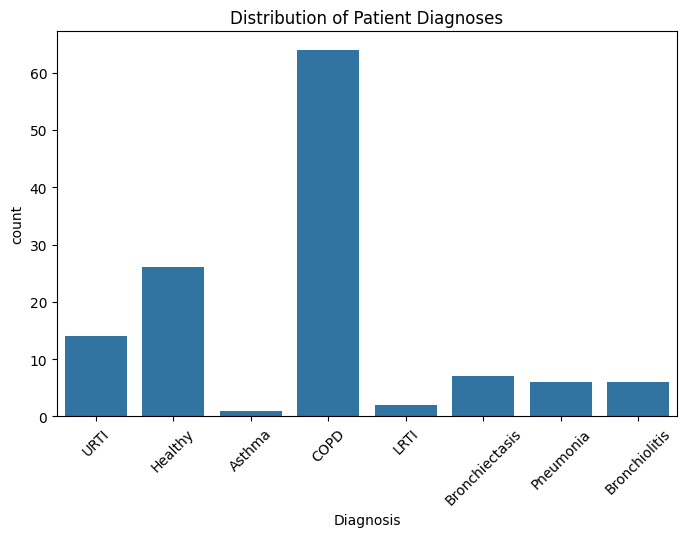

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Diagnosis')
plt.title("Distribution of Patient Diagnoses")
plt.xticks(rotation=45)
plt.show()

This bar chart shows the distribution of patient diagnoses in the dataset by count.

### Dominant and Minority Classes

- **COPD** (Chronic Obstructive Pulmonary Disease) is the most represented diagnosis by far, with over 60 patients, making it the majority class in this sample.
- **Healthy** individuals form the second largest group, with just over 25 cases, providing a sizeable control population for comparative analysis.
- **URTI** (Upper Respiratory Tract Infection) is also notable, but substantially fewer than COPD and Healthy, with around 15 cases.
- Diagnoses like **Asthma, LRTI** (Lower Respiratory Tract Infection), **Bronchiectasis**, **Pneumonia**, and **Bronchiolitis** are minority classes, each with less than 10 cases, indicating limited sampling or rarity in the dataset.

### Analytical Implications

- The diagnosis distribution is highly imbalanced, especially with the dominance of COPD and the scarcity of less common conditions.
- Models trained on this dataset may require strategies to handle class imbalance, such as oversampling minority classes, using class weights, or designing specific evaluation metrics to prevent bias toward COPD detection.
- The strong representation of Healthy and COPD is beneficial for discriminative modeling but highlights the risk of reduced sensitivity and lower generalizability for rare diseases (e.g., Asthma, Bronchiolitis).

### Epidemiological Considerations

- High COPD counts may reflect real-world prevalence patterns, especially in older, smoking, or at-risk populations, or could be due to targeted recruitment in the dataset.
- The rarity of asthma and select infections could indicate these conditions are less prevalent in the sampled cohort or might result from inclusion criteria and annotation emphasis.

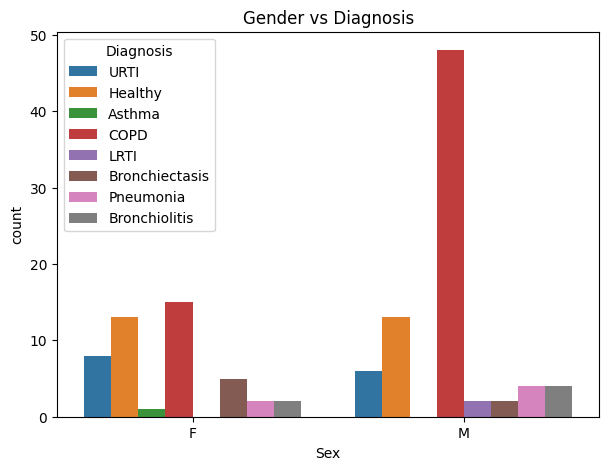

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Sex', hue='Diagnosis')
plt.title("Gender vs Diagnosis")
plt.show()

This grouped bar chart displays counts of recordings by diagnosis and sex (female "F" and male "M") for several respiratory conditions.

### Major Trends

- **COPD** (Chronic Obstructive Pulmonary Disease) shows a strong male predominance, with more than triple the number of male cases compared to females.
- **Healthy** individuals are distributed equally between sexes, suggesting the reference population is balanced.
- **URTI** (Upper Respiratory Tract Infection), **Bronchiectasis**, **Pneumonia**, and **Bronchiolitis** have lower and fairly balanced counts across both sexes, indicating no strong gender bias in sample collection for these conditions.

### Observations

- **Asthma** is notably rare in this subset, with only 1 female case and none in males—highlighting potential sampling or annotation limitations for this diagnosis.
- **LRTI** (Lower Respiratory Tract Infection) is more frequent in males but remains one of the less common classes overall.

#### **Overview of Audio-Based Labels**

In [ ]:
labels_df_recreated = file_label_df.sort_values(by='filename')
summary = labels_df_recreated.groupby('filename').sum()

# Re-apply the logic
conditions = [
    (summary['crackles only'] == 0) &
    (summary['wheezes only'] == 0) &
    (summary['crackles and wheezees'] == 0),

    (summary['crackles only'] == summary.max(axis=1)),
    (summary['wheezes only'] == summary.max(axis=1)),
    (summary['crackles and wheezees'] == summary.max(axis=1)),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['crackles only'] > summary['wheezes only']) &
    (summary['crackles only'] > summary['crackles and wheezees']),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['wheezes only'] >= summary['crackles only']) &
    (summary['wheezes only'] > summary['crackles and wheezees']),

    (summary['no label'] == summary.max(axis=1)) &
    (summary['crackles and wheezees'] >= summary['crackles only']) &
    (summary['crackles and wheezees'] >= summary['wheezes only']),
]

values = [
    'Healthy',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles'
]

summary['diagnosis'] = np.select(conditions, values, default='Unknown')

# Reset the index to make 'filename' a regular column, which is often easier for merging.
# This ensures the actual filenames are in a column named 'filename'.
summary = summary.reset_index().rename(columns={'index': 'filename'})

# Ensure the 'filename' column is explicitly string type to use .str accessor reliably
summary['filename'] = summary['filename'].astype(str)

# Extract Patient number from the 'filename' column
# The filename format is 'PATIENT_NUMBER_RECORDING_INDEX_...'
summary['Patient number'] = summary['filename'].str.split('_').str[0].astype(int)

# Rename the existing audio-based diagnosis column before merging to avoid name collision
summary = summary.rename(columns={'diagnosis': 'audio_diagnosis'})

# Merge with the main demographic and diagnosis DataFrame (df)
# Select only the 'Patient number' and 'Diagnosis' columns from df
# Assuming 'df' is available from previous cells
df_patient_diagnosis = df[['Patient number', 'Diagnosis']].drop_duplicates(subset=['Patient number'])

# Perform the merge. The clinical diagnosis column will be named 'Diagnosis'.
summary = pd.merge(summary, df_patient_diagnosis, on='Patient number', how='left')

# Rename the merged clinical 'Diagnosis' column for clarity
summary = summary.rename(columns={'Diagnosis': 'clinical_diagnosis'})

summary.head()

filename  no label  crackles only  wheezes only  \
0  101_1b1_Al_sc_Meditron        12              0             0   
1  101_1b1_Pr_sc_Meditron        11              0             0   
2  102_1b1_Ar_sc_Meditron        13              0             0   
3  103_2b2_Ar_mc_LittC2SE         2              0             4   
4  104_1b1_Al_sc_Litt3200         6              0             0   

   crackles and wheezees audio_diagnosis  Patient number clinical_diagnosis  
0                      0         Healthy             101               URTI  
1                      0         Healthy             101               URTI  
2                      0         Healthy             102            Healthy  
3                      0         Wheezes             103             Asthma  
4                      0         Healthy             104               COPD

# Overview of Audio VS Demographic Datasets

In [ ]:
columns_to_check = ['Age', 'Sex', 'Diagnosis', 'audio_diagnosis']

# Extract 'Patient number' from the 'filename' column of the 'summary' DataFrame
summary_with_patient_id = summary.copy()
summary_with_patient_id['Patient number'] = summary_with_patient_id['filename'].str.split('_').str[0].astype(int)

# Merge df (demographic/clinical diagnosis) with summary (audio-based diagnosis)
# Only select the patient number and the audio-based diagnosis from summary_with_patient_id
merged_data = df.merge(summary_with_patient_id[['Patient number', 'audio_diagnosis']], on='Patient number', how='inner')

cleaned_merged_data = merged_data.dropna(subset=columns_to_check).copy()

print(f"Original merged_data shape: {merged_data.shape}")
print(f"Cleaned merged_data shape: {cleaned_merged_data.shape}")

print("First 5 rows of cleaned_merged_data:")
cleaned_merged_data.head()

Original merged_data shape: (920, 8)
Cleaned merged_data shape: (914, 8)
First 5 rows of cleaned_merged_data:


Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F                NaN               19.0   
1             101   3.00   F                NaN               19.0   
2             102   0.75   F                NaN                9.8   
3             103  70.00   F              33.00                NaN   
4             104  70.00   F              28.47                NaN   

   Child Height (cm) Diagnosis audio_diagnosis  
0               99.0      URTI         Healthy  
1               99.0      URTI         Healthy  
2               73.0   Healthy         Healthy  
3                NaN    Asthma         Wheezes  
4                NaN      COPD         Healthy

##Analyze Age vs. Respiratory Sound Patterns (ANOVA)

In [ ]:
# Get unique values from the 'diagnosis' column
relevant_audio_diagnoses = cleaned_merged_data['audio_diagnosis'].unique()

# Create a list of age arrays for each audio-based diagnosis group
age_groups_audio = [cleaned_merged_data['Age'][cleaned_merged_data['audio_diagnosis'] == d].dropna() for d in relevant_audio_diagnoses]

# Perform one-way ANOVA test
f_statistic_audio, p_value_audio = f_oneway(*age_groups_audio)

# Calculate degrees of freedom
df_between_audio = len(relevant_audio_diagnoses) - 1
df_within_audio = sum(len(group) for group in age_groups_audio) - len(relevant_audio_diagnoses)

# Calculate eta-squared (η²) and eta (η)
eta_squared_audio = (f_statistic_audio * df_between_audio) / (f_statistic_audio * df_between_audio + df_within_audio)
eta_age_audio = np.sqrt(eta_squared_audio)

print(f"One-way ANOVA for Age vs. Respiratory Sound Patterns:")
print(f"F-statistic: {f_statistic_audio:.3f}")
print(f"P-value: {p_value_audio:.3f}")
print(f"Correlation Ratio (η) for Age vs. Respiratory Sound Patterns: {eta_age_audio:.3f}")

One-way ANOVA for Age vs. Respiratory Sound Patterns:
F-statistic: 17.229
P-value: 0.000
Correlation Ratio (η) for Age vs. Respiratory Sound Patterns: 0.232


One-way ANOVA shows a statistically significant difference in mean age across audio-based diagnosis groups (F(2, N−3) = 17.23, p < 0.001). However, the correlation ratio (η = 0.232; η² ≈ 0.054) indicates a **small effect** — only ~5.4% of age variance is explained by diagnosis group. Clinically, older participants appear slightly more likely to have crackles or mixed findings, but age alone is a weak predictor of respiratory sound class and should not be used as a surrogate for diagnostic category.

## Analyze Gender vs. Respiratory Sound Patterns (Chi-squared)

In [ ]:
# 1. Create a contingency table
contingency_table_audio = pd.crosstab(cleaned_merged_data['Sex'], cleaned_merged_data['audio_diagnosis'])

# 3. Perform the Chi-squared test of independence
chi2_audio, p_audio, dof_audio, expected_audio = chi2_contingency(contingency_table_audio)

# 4. Print the chi-squared statistic and the p-value
print(f"Chi-squared statistic for Gender vs. Respiratory Sound Patterns: {chi2_audio:.3f}")
print(f"P-value for Gender vs. Respiratory Sound Patterns: {p_audio:.3f}")

Chi-squared statistic for Gender vs. Respiratory Sound Patterns: 25.522
P-value for Gender vs. Respiratory Sound Patterns: 0.000


In [ ]:
def calculate_cramers_v(contingency_table, chi2):
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape)
    v = np.sqrt(chi2 / (n * (min_dim - 1)))
    return v

cramers_v_audio = calculate_cramers_v(contingency_table_audio, chi2_audio)
print(f"Cramers V for Gender vs. Respiratory Sound Patterns: {cramers_v_audio:.3f}")

Cramers V for Gender vs. Respiratory Sound Patterns: 0.167


The Chi-squared test showed a statistically significant association between gender and audio-based diagnosis (χ² = 25.52, p < 0.001). However, the effect size was small (Cramer's V = 0.167), indicating that gender has only a **weak relationship** with the presence of crackles, wheezes, or combined sounds. Gender should therefore not be considered a strong predictor of respiratory sound category.

## Analyze Age vs. Clinical Diagnosis (ANOVA)

In [ ]:
# 1. Get unique values from the 'Diagnosis' column
demographic_diagnoses = cleaned_merged_data['Diagnosis'].unique()

# 2. Create a list of age arrays for each demographic diagnosis group
age_groups_demographic = [cleaned_merged_data['Age'][cleaned_merged_data['Diagnosis'] == d].dropna() for d in demographic_diagnoses]

# 3. Perform one-way ANOVA test
f_statistic_demographic, p_value_demographic = f_oneway(*age_groups_demographic)

# Calculate degrees of freedom
df_between_demographic = len(demographic_diagnoses) - 1
df_within_demographic = sum(len(group) for group in age_groups_demographic) - len(demographic_diagnoses)

# Calculate eta-squared (η²) and eta (η)
eta_squared_demographic = (f_statistic_demographic * df_between_demographic) / (f_statistic_demographic * df_between_demographic + df_within_demographic)
eta_age_demographic = np.sqrt(eta_squared_demographic)

# 4. Print the F-statistic and p-value
print(f"One-way ANOVA for Age vs. Clinical Diagnoses:")
print(f"F-statistic: {f_statistic_demographic:.3f}")
print(f"P-value: {p_value_demographic:.3f}")
print(f"Correlation Ratio (η) for Age vs. Clinical Diagnoses: {eta_age_demographic:.3f}")

One-way ANOVA for Age vs. Clinical Diagnoses:
F-statistic: 418.525
P-value: 0.000
Correlation Ratio (η) for Age vs. Clinical Diagnoses: 0.874


One-way ANOVA revealed a highly significant difference in age across demographic diagnosis groups (F = 418.53, p < 0.001). The **correlation ratio was very large(η = 0.874, η² ≈ 0.763)**, indicating that diagnosis category strongly depends on age. Approximately 76% of the variance in age is explained by diagnostic group assignment, reflecting the well-known age-related distribution of diseases such as COPD (older adults) versus asthma (younger individuals).

## Analyze Gender vs. Clinical Diagnosis (Chi-squared)

In [ ]:
# 1. Create a contingency table
contingency_table_demographic = pd.crosstab(cleaned_merged_data['Sex'], cleaned_merged_data['Diagnosis'])

# 2. Perform the Chi-squared test of independence
chi2_demographic, p_demographic, dof_demographic, expected_demographic = chi2_contingency(contingency_table_demographic)

# 3. Print the chi-squared statistic and the p-value
print(f"Chi-squared statistic for Gender vs. Clinical Diagnoses: {chi2_demographic:.3f}")
print(f"P-value for Gender vs. Clinical Diagnoses: {p_demographic:.3f}")

Chi-squared statistic for Gender vs. Clinical Diagnoses: 31.036
P-value for Gender vs. Clinical Diagnoses: 0.000


In [ ]:
cramers_v_demographic = calculate_cramers_v(contingency_table_demographic, chi2_demographic)
print(f"Cramers V for Gender vs. Clinical Diagnoses: {cramers_v_demographic:.3f}")

Cramers V for Gender vs. Clinical Diagnoses: 0.184


This shows a **statistically significant** association between gender and respiratory diagnoses (p = 0.000), indicating that certain conditions are more common in one gender than the other. However, the **strength of this association is weak to moderate** (Cramér’s V = 0.184), meaning gender alone is not a strong predictor of diagnosis. Clinically, while slight gender trends may exist, gender should be considered alongside other features for accurate assessment or modeling.

#### **Example Waveform and Spectrogram Visual**

In [ ]:
i = 100
sound_filename = root + file_label_df['filename'][i] + '.wav'

In [ ]:
ipd.Audio(sound_filename, rate=16000)

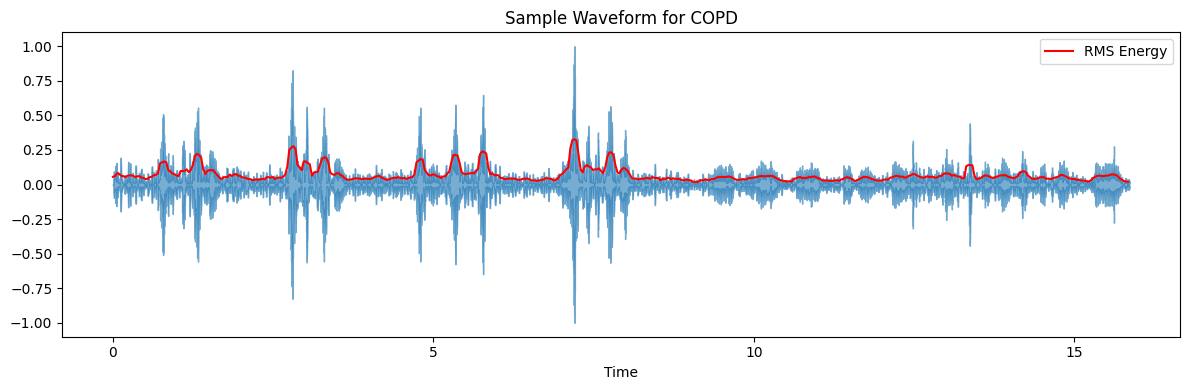

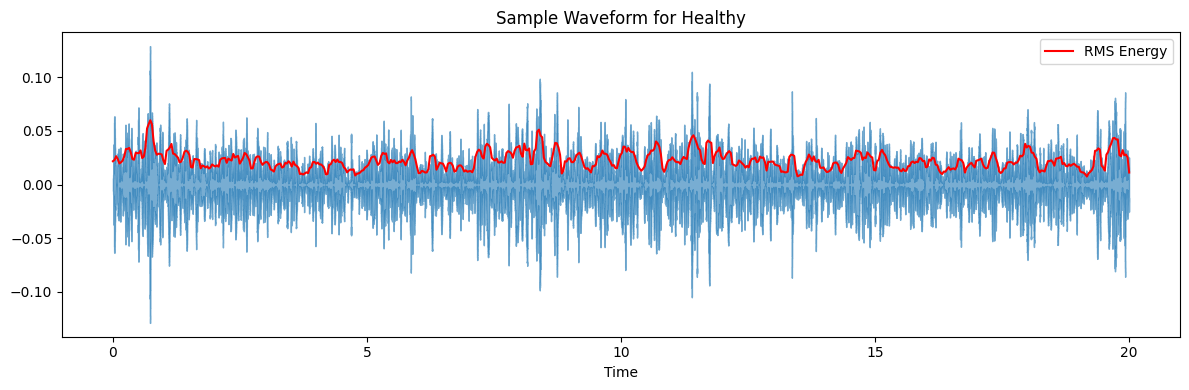

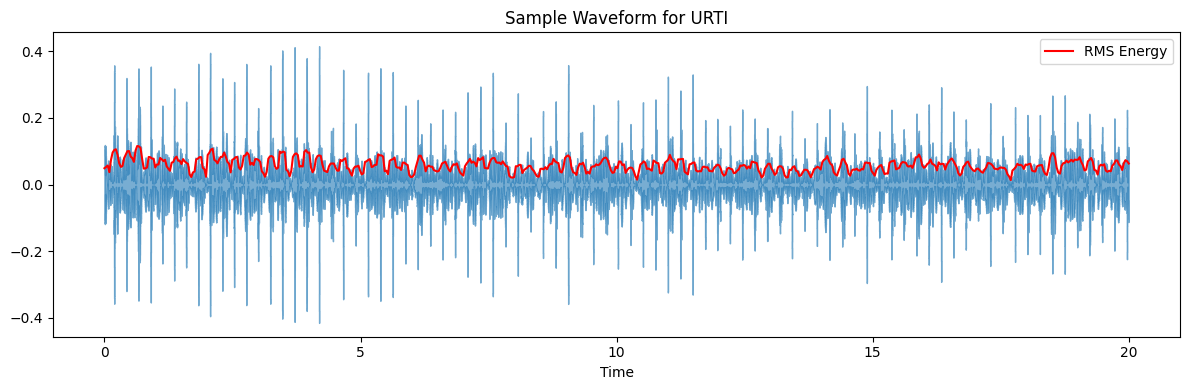

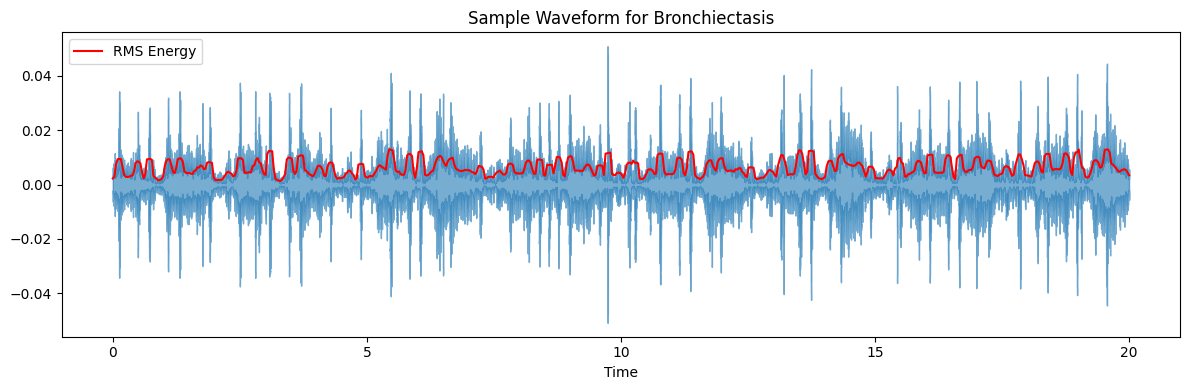

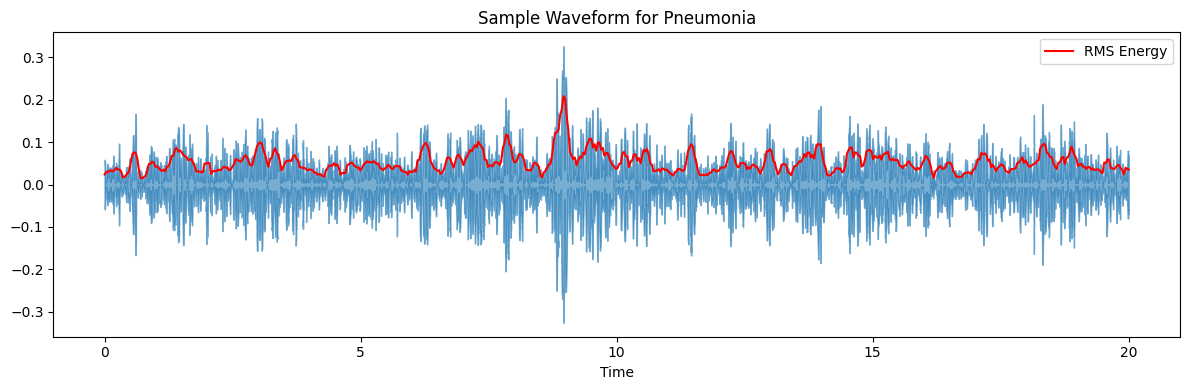

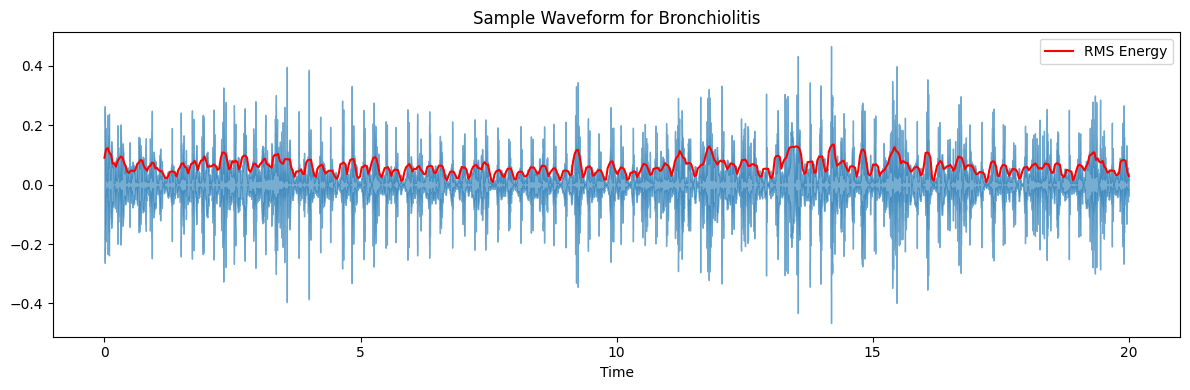

In [ ]:
target_diagnoses = ['COPD', 'Healthy', 'URTI', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']

# Define hop_length explicitly so both RMS and Time calculation use the same value
hop_length = 512

for diagnosis_type in target_diagnoses:
    # Find the first filename for the current diagnosis type
    # Note: Ensure 'summary' dataframe and 'root' path are defined in your environment
    # The 'filename' column must be present in the 'summary' DataFrame after jo2rAMCoOT09 is run correctly.
    example_filename = summary[summary['clinical_diagnosis'] == diagnosis_type]['filename'].iloc[0]

    # Construct the full path to the WAV file
    wav_path = os.path.join(root, example_filename + '.wav')

    # Load the audio file
    x, sr = librosa.load(wav_path, sr=16000)

    # Calculate RMS energy
    # Explicitly passing hop_length ensures consistency
    rms = librosa.feature.rms(y=x, hop_length=hop_length)

    # We must tell times_like what the SR and hop_length are
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length)

    # Create a figure and axes for plotting
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 1, 1)

    # Plot the waveform
    librosa.display.waveshow(y=x, sr=sr, ax=ax, alpha=0.6)

    # Overlay the RMS envelope
    ax.plot(times, rms[0], color='r', linestyle='-', label='RMS Energy')
    ax.legend()

    # Set plot title
    ax.set(title=f'Sample Waveform for {diagnosis_type}')
    plt.tight_layout()
    plt.show()

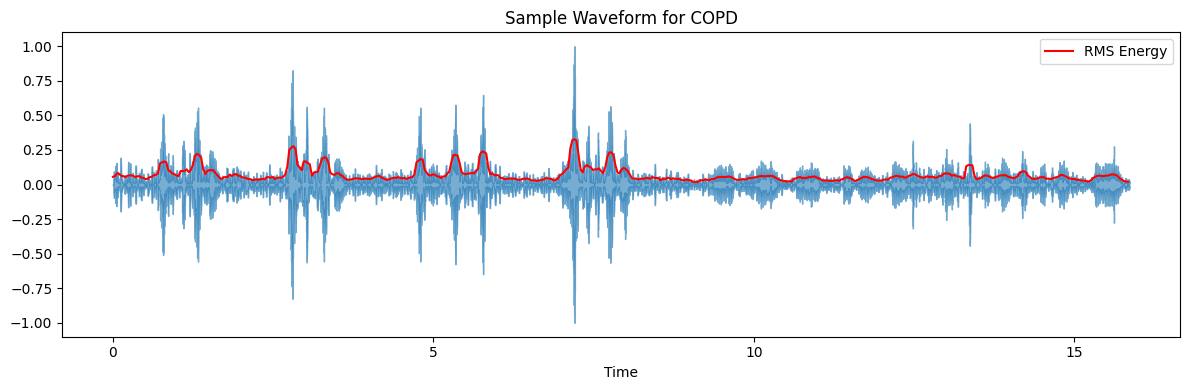

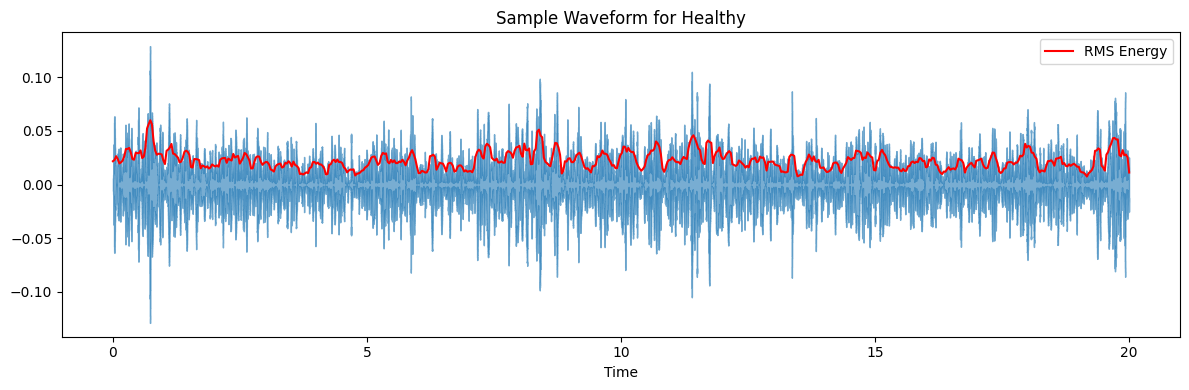

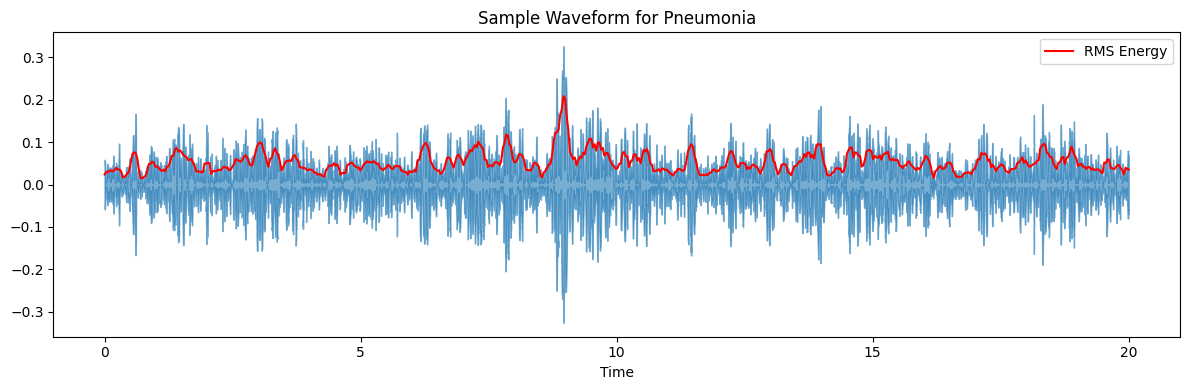

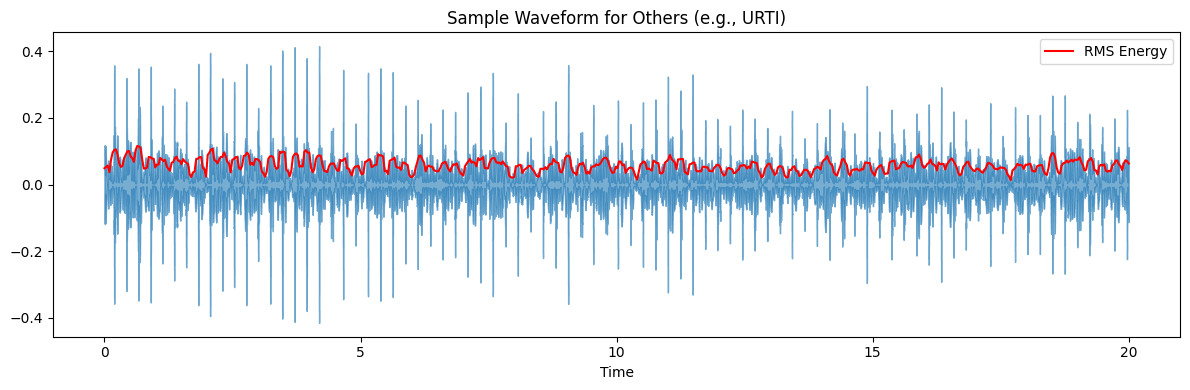

In [ ]:
target_plot_categories = ['COPD', 'Healthy', 'Pneumonia', 'Others']

hop_length = 512

for category_type in target_plot_categories:
    if category_type == 'Others':
        # Select one diagnosis from the 'Others' group to represent it
        # 'URTI' is chosen as a representative example from the 'Others' group
        example_diagnosis_for_others = 'URTI'
        example_filename = summary[summary['clinical_diagnosis'] == example_diagnosis_for_others]['filename'].iloc[0]
        plot_title_diagnosis = f'Sample Waveform for {category_type} (e.g., {example_diagnosis_for_others})'
    else:
        example_filename = summary[summary['clinical_diagnosis'] == category_type]['filename'].iloc[0]
        plot_title_diagnosis = f'Sample Waveform for {category_type}'

    # Construct the full path to the WAV file
    wav_path = os.path.join(root, example_filename + '.wav')

    # Load the audio file
    x, sr = librosa.load(wav_path, sr=16000)

    # Calculate RMS energy
    rms = librosa.feature.rms(y=x, hop_length=hop_length)

    # Define times for RMS envelope
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length)

    # Create a figure and axes for plotting
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 1, 1)

    # Plot the waveform
    librosa.display.waveshow(y=x, sr=sr, ax=ax, alpha=0.6)

    # Overlay the RMS envelope
    ax.plot(times, rms[0], color='r', linestyle='-', label='RMS Energy')
    ax.legend()

    # Set plot title
    ax.set(title=plot_title_diagnosis)
    plt.tight_layout()
    plt.show()

## Extract Audio Features

In [ ]:
# 1. Re-create summary DataFrame with clinical diagnosis to ensure data consistency
labels_df_recreated = file_label_df.sort_values(by='filename')
summary_temp = labels_df_recreated.groupby('filename').sum()

conditions = [
    (summary_temp['crackles only'] == 0) &
    (summary_temp['wheezes only'] == 0) &
    (summary_temp['crackles and wheezees'] == 0),

    (summary_temp['crackles only'] == summary_temp.max(axis=1)),
    (summary_temp['wheezes only'] == summary_temp.max(axis=1)),
    (summary_temp['crackles and wheezees'] == summary_temp.max(axis=1)),

    (summary_temp['no label'] == summary_temp.max(axis=1)) &
    (summary_temp['crackles only'] > summary_temp['wheezes only']) &
    (summary_temp['crackles only'] > summary_temp['crackles and wheezees']),

    (summary_temp['no label'] == summary_temp.max(axis=1)) &
    (summary_temp['wheezes only'] >= summary_temp['crackles only']) &
    (summary_temp['wheezes only'] > summary_temp['crackles and wheezees']),

    (summary_temp['no label'] == summary_temp.max(axis=1)) &
    (summary_temp['crackles and wheezees'] >= summary_temp['crackles only']) &
    (summary_temp['crackles and wheezees'] >= summary_temp['wheezes only']),
]

values = [
    'Healthy',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles',
    'Crackles',
    'Wheezes',
    'Wheezes & Crackles'
]

summary_temp['diagnosis'] = np.select(conditions, values, default='Unknown')

# Reset the index to make 'filename' a regular column
summary_merged = summary_temp.reset_index().rename(columns={'index': 'filename'})

# Ensure the 'filename' column is explicitly string type
summary_merged['filename'] = summary_merged['filename'].astype(str)

# Extract Patient number from the 'filename' column
summary_merged['Patient number'] = summary_merged['filename'].str.split('_').str[0].astype(int)

# Rename the existing audio-based diagnosis column
summary_merged = summary_merged.rename(columns={'diagnosis': 'audio_diagnosis'})

# Merge with the main demographic and diagnosis DataFrame (df)
df_patient_diagnosis = df[['Patient number', 'Diagnosis']].drop_duplicates(subset=['Patient number'])
summary_merged = pd.merge(summary_merged, df_patient_diagnosis, on='Patient number', how='left')

# Rename the merged clinical 'Diagnosis' column for clarity
summary_merged = summary_merged.rename(columns={'Diagnosis': 'clinical_diagnosis'})

print("Recreated summary_merged DataFrame with clinical diagnosis.")

# 2. & 3. Extract Audio Features and create features_df
all_audio_features = []
sr_new = 16000 # Standardize sample rate to 16kHz for feature extraction

for index, row in tqdm(summary_merged.iterrows(), total=summary_merged.shape[0], desc="Extracting Audio Features"):
    filename = row['filename']
    clinical_diagnosis = row['clinical_diagnosis']
    audio_diagnosis = row['audio_diagnosis']

    wav_path = os.path.join(root, filename + '.wav')

    try:
        y, sr_original = librosa.load(wav_path, sr=None) # Load with original sample rate

        # Resample if original sample rate is different from target
        if sr_original != sr_new:
            y_resampled = librosa.resample(y=y, orig_sr=sr_original, target_sr=sr_new)
        else:
            y_resampled = y

        # Calculate duration
        duration = len(y_resampled) / sr_new # Use resampled length and new SR

        # Calculate Spectral Centroid
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_resampled, sr=sr_new))

        # Calculate Spectral Bandwidth
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_resampled, sr=sr_new))

        # Calculate Spectral Roll-off
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_resampled, sr=sr_new))

        # Calculate Spectral Flux using onset_strength as a proxy
        onset_env = librosa.onset.onset_strength(y=y_resampled, sr=sr_new)
        spectral_flux = np.mean(onset_env)

        all_audio_features.append({
            'filename': filename,
            'clinical_diagnosis': clinical_diagnosis,
            'audio_diagnosis': audio_diagnosis,
            'original_sample_rate': sr_original,
            'duration_sec': duration,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'spectral_flux': spectral_flux
        })

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        all_audio_features.append({
            'filename': filename,
            'clinical_diagnosis': clinical_diagnosis,
            'audio_diagnosis': audio_diagnosis,
            'original_sample_rate': None,
            'duration_sec': None,
            'spectral_centroid': None,
            'spectral_bandwidth': None,
            'spectral_rolloff': None,
            'spectral_flux': None
        })

features_df = pd.DataFrame(all_audio_features)
print("Audio feature extraction complete.")

# 4. Group by clinical_diagnosis and aggregate, creating a new 'grouped_clinical_diagnosis'
def group_diagnoses_for_mean_features(diagnosis):
    if diagnosis in ['Healthy', 'COPD', 'Pneumonia']:
        return diagnosis
    else:
        return 'Others'

features_df['grouped_clinical_diagnosis'] = features_df['clinical_diagnosis'].apply(group_diagnoses_for_mean_features)

mean_features_by_grouped_clinical_diagnosis = features_df.groupby('grouped_clinical_diagnosis').agg(
    **{
        'Mean Sample Rate (Hz)': ('original_sample_rate', 'mean'),
        'Mean Duration (s)': ('duration_sec', 'mean'),
        'Min Duration (s)': ('duration_sec', 'min'),
        'Max Duration (s)': ('duration_sec', 'max'),
        'Mean Spectral Centroid (Hz)': ('spectral_centroid', 'mean'),
        'Mean Spectral Bandwidth (Hz)': ('spectral_bandwidth', 'mean'),
        'Mean Spectral Rolloff (Hz)': ('spectral_rolloff', 'mean'),
        'Mean Spectral Flux (Hz)': ('spectral_flux', 'mean')
    }
)

# 5. Filter for requested diagnoses
target_display_diagnoses = ['Healthy', 'COPD', 'Pneumonia', 'Others']

# Handle cases where a diagnosis might not be present in the grouped results
filtered_mean_features = mean_features_by_grouped_clinical_diagnosis.reindex(target_display_diagnoses).copy()

Recreated summary_merged DataFrame with clinical diagnosis.


Extracting Audio Features:   0%|          | 0/920 [00:00<?, ?it/s]

Audio feature extraction complete.


In [ ]:
display(filtered_mean_features)

Mean Sample Rate (Hz)  Mean Duration (s)  \
grouped_clinical_diagnosis                                             
Healthy                              44100.000000          19.986857   
COPD                                 39290.920555          21.732459   
Pneumonia                            44100.000000          20.000000   
Others                               44100.000000          19.993655   

                            Min Duration (s)  Max Duration (s)  \
grouped_clinical_diagnosis                                       
Healthy                               19.800         20.000000   
COPD                                   7.856         86.200000   
Pneumonia                             20.000         20.000000   
Others                                19.820         20.000062   

                            Mean Spectral Centroid (Hz)  \
grouped_clinical_diagnosis                                
Healthy                                      209.567730   
COPD                                         353.635311   
Pneumonia                                    138.338795   
Others                                       229.009911   

                            Mean Spectral Bandwidth (Hz)  \
grouped_clinical_diagnosis                                 
Healthy                                       719.838010   
COPD                                          884.412032   
Pneumonia                                     565.168151   
Others                                        655.560376   

                            Mean Spectral Rolloff (Hz)  \
grouped_clinical_diagnosis                               
Healthy                                     219.702667   
COPD                                        519.429352   
Pneumonia                                   131.423843   
Others                                      282.665291   

                            Mean Spectral Flux (Hz)  
grouped_clinical_diagnosis                           
Healthy                                    0.777009  
COPD                                       0.834581  
Pneumonia                                  0.540922  
Others                                     0.821843

/tmp/ipython-input-1969003633.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1969003633.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1969003633.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1969003633.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


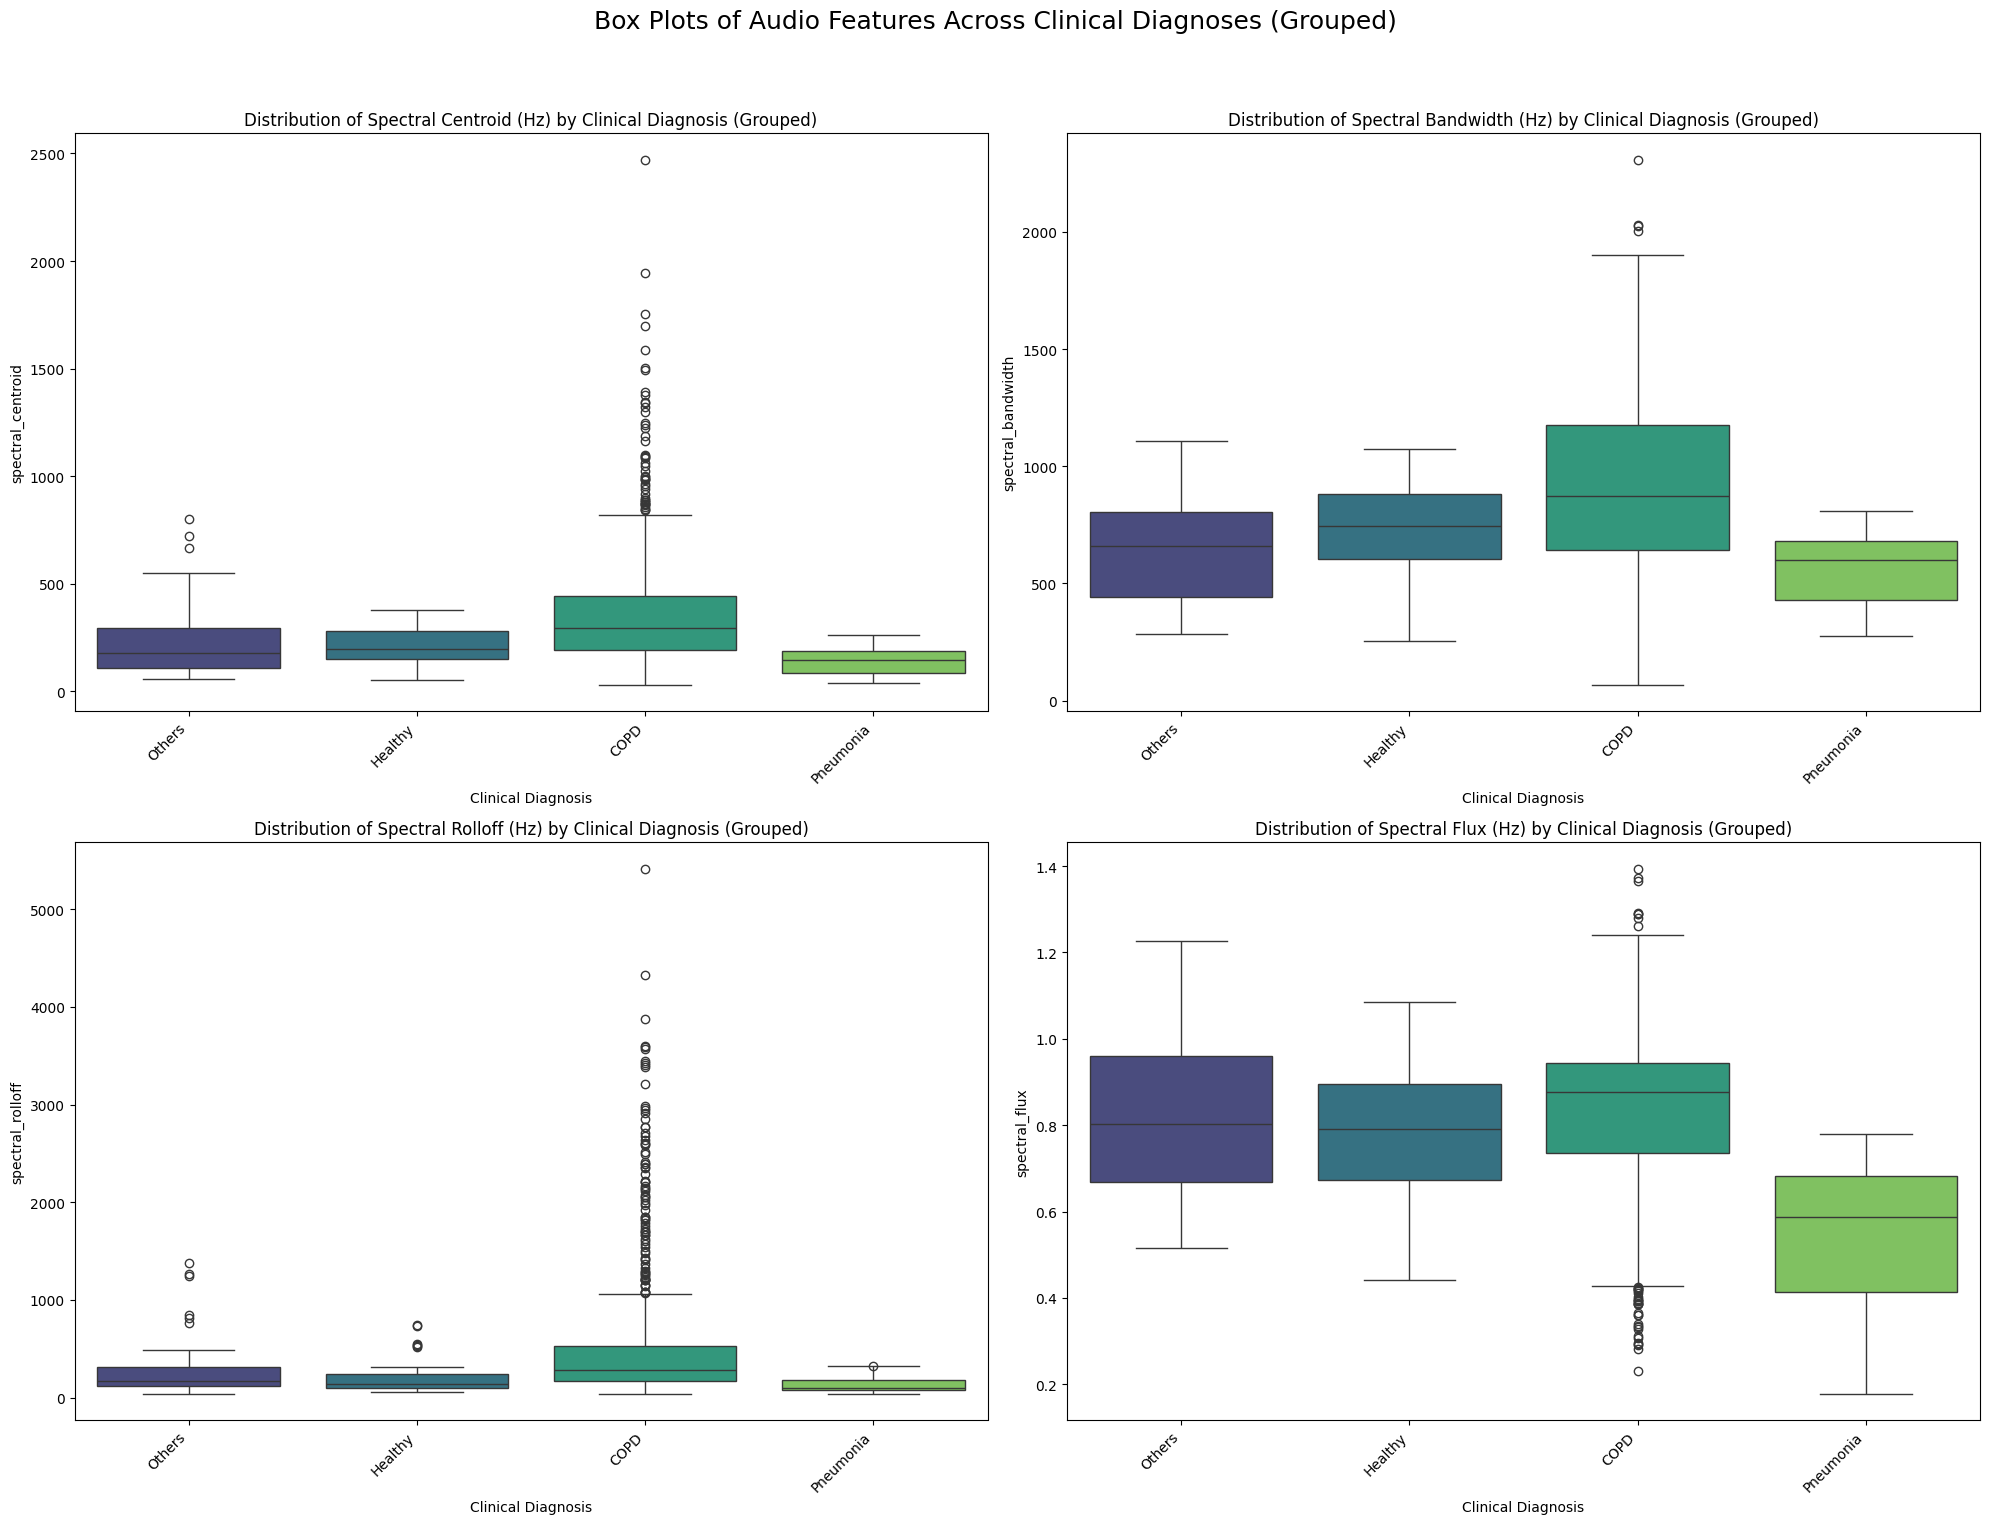

In [ ]:
features_to_plot = [
    'spectral_centroid',
    'spectral_bandwidth',
    'spectral_rolloff',
    'spectral_flux'
]

# For display purposes in the title, we can map the internal column names to more readable names
feature_display_names = {
    'spectral_centroid': 'Spectral Centroid (Hz)',
    'spectral_bandwidth': 'Spectral Bandwidth (Hz)',
    'spectral_rolloff': 'Spectral Rolloff (Hz)',
    'spectral_flux': 'Spectral Flux (Hz)'
}

# Create a new 'grouped_diagnosis' column
def group_diagnoses(diagnosis):
    if diagnosis in ['Healthy', 'COPD', 'Pneumonia']:
        return diagnosis
    else:
        return 'Others'

features_df_grouped = features_df.copy()
features_df_grouped['grouped_diagnosis'] = features_df_grouped['clinical_diagnosis'].apply(group_diagnoses)

plt.figure(figsize=(20, 16))

for i, feature_col_name in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns
    sns.boxplot(
        data=features_df_grouped,
        x='grouped_diagnosis', # Use the new grouped diagnosis column
        y=feature_col_name, # Use the actual column name
        palette='viridis'
    )
    plt.title(f'Distribution of {feature_display_names[feature_col_name]} by Clinical Diagnosis (Grouped)') # Use display name in title
    plt.xlabel('Clinical Diagnosis') # Add a clear label for the x-axis
    plt.xticks(rotation=45, ha='right')

plt.suptitle('Box Plots of Audio Features Across Clinical Diagnoses (Grouped)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()